## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important to get some practice working with the difficulties of these. 

For this project, I worked to understand the results of an A/B test run by an e-commerce website. My goal was to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import math
import statsmodels.stats.api as sms
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)

In [2]:
df = pd.read_csv('ab_data.csv')

print("Number of rows: ", df.shape[0], " Number of columns: ", df.shape[1])
df.head()

Number of rows:  294478  Number of columns:  5


,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [3]:
# The number of unique users in the dataset
df.nunique()[0]

290584

In [4]:
# The number of duplicated users in the dataset
df.shape[0] - df.nunique()[0]

3894

In [5]:
# The proportion of users converted
len(df.query('converted == 1'))/df.shape[0]

0.11965919355605512

In [6]:
# Any of the rows have missing values
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

The rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page** need to be removed since we cannot be sure if the row truly received the new or old page. In this case, we only selected the rows where `treatment` is aligned with `new_page` or `control` with `old_page`.


In [7]:
df2 = df[((df.group=='treatment') & (df.landing_page=='new_page')) | ((df.group=='control') & (df.landing_page=='old_page'))]
print("Number of rows: ", df2.shape[0], " Number of columns: ", df2.shape[1])
df2.head()

Number of rows:  290585  Number of columns:  5


,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [8]:
# Double Check all of the correct rows were removed 
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [9]:
# The number of unique users in the dataset
df2.user_id.nunique()

290584

In [10]:
#user_id repeated in df2
df2.user_id[df2.user_id.duplicated()]

2893    773192
Name: user_id, dtype: int64

In [11]:
#the row information for the repeat user_i
df2[df2.user_id.duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,37:58.8,treatment,new_page,0
2893,773192,55:59.6,treatment,new_page,0


In [12]:
df2[df2.duplicated(subset='user_id', keep='last')] # Determines which duplicates (if any) to mark.

,user_id,timestamp,group,landing_page,converted
1899,773192,37:58.8,treatment,new_page,0


In [13]:
#  Remove one of the rows with a duplicate user_id (latter one)
#  drop_duplicates (keep = default ‘first’)
df3 = df2.drop_duplicates(subset='user_id', keep='first')


# - first : Drop duplicates except for the first occurrence. 
# - last : Drop duplicates except for the last occurrence. 
# - False : Drop all duplicates.

In [14]:
print("Number of rows: ", df3.shape[0], " Number of columns: ", df3.shape[1])
df3.head()

Number of rows:  290584  Number of columns:  5


,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [15]:
# ratio of converted (1 for yes case) over the number of rows
df3.converted.mean()

0.11959708724499628

In [16]:
# probaility of being converted in the control group
df3.query('group=="control"').converted.mean()

0.1203863045004612

In [17]:
# probaility of being converted in the treatment group
df3.query('group=="treatment"').converted.mean()

0.11880806551510564

Text(0, 0.5, '')

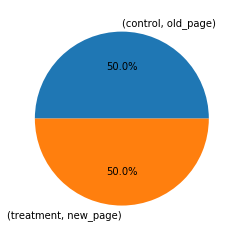

In [18]:
#probability that an individual received the new page (as a treatment group) or the old page (as a control group)
df3.groupby(['group','landing_page']).size().plot.pie(figsize=(4,4),autopct='%1.1f%%')
plt.ylabel("")

Text(0, 0.5, '')

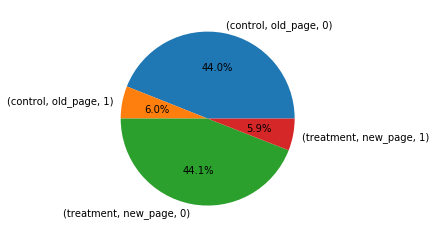

In [19]:
#probability that an individual received the new page (as a treatment group) or the old page (as a control group)
df3.groupby(['group','landing_page','converted']).size().plot.pie(figsize=(4,4),autopct='%1.1f%%')
plt.ylabel("")

**In terms of having any causation between the `new treatment` page and `converted` from the table (without more information on this), I would say there is not sufficient evidence from the table itself. Otherwise, if having the correlation between them, the probabilities of the `conversions` given in the `control` group and the `treatment` group, respectively, are simliar, so the results are not sufficient evidence to determine that the new treatment page leads to more conversions.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, we could technically run a hypothesis test continuously as each observation was observed.  

**However, then the hard question is do we stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  These questions are the difficult parts associated with A/B tests in general.**  


For now, consider we need to make the decision just based on all the data provided.  If we want to assume that the old page is better unless the new page proves to be definitely better `at a Type I error rate of 5%`, what should your null and alternative hypotheses be?  

The hypothesis is stated in terms of **$p_{old}$** and **$p_{new}$** , which are the converted rates for the old and new pages.

<center>$H_{1}$: $p_{new}$ - $p_{old}$ > 0</center>

In this section, we are going to do the following.

1. Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

- Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

- Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

- Use the cells below to provide the necessary parts of this simulation.   <br><br>

In [20]:
#  convert rate for new page under the null (assuming it is eqaul to the converted success rate of all data in the dataset)
p_new = len(df3.query('converted==1'))/len(df3)
p_new

0.11959708724499628

In [21]:
#convert rate for old page  under the null (assuming it is eqaul to the converted success rate of all data in the dataset)
p_old = len(df3.query('converted==1'))/len(df3)
p_old

0.11959708724499628

In [22]:
# number of the new_page
n_new = len(df3.query('landing_page=="new_page"'))
n_new

145310

In [23]:
# number of the old_page
n_old = len(df3.query('landing_page=="old_page"'))
n_old

145274

Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
new_page_converted = np.random.choice([0,1], n_new, p = [p_new, 1-p_new])
new_page_converted

array([1, 1, 1, ..., 1, 1, 1])

In [25]:
new_page_converted.sum()/n_new +p_new

1.000589448403898

Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [26]:
old_page_converted = np.random.choice([0, 1], n_old, p = [p_old, 1-p_old])
old_page_converted

array([1, 1, 1, ..., 1, 1, 1])

In [27]:
old_page_converted.sum()/n_old + p_old

0.9992314333771328

Find $p_{new}$ - $p_{old}$ for your simulated values

In [28]:
diff= new_page_converted.mean() - old_page_converted.mean()
diff

0.0013580150267651359

Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process above and store all 10,000 values in a numpy array called **p_diffs**.

In [29]:

p_diffs = np.empty(10000)
for i in range(10000):
    
    p_new_ = np.random.choice([0, 1], n_new, replace = True, p = [p_new, 1-p_new])
    p_old_ = np.random.choice([0, 1], n_old, replace = True, p = [p_old, 1-p_old])
    p_diffs[i] = p_new_.mean() - p_old_.mean()


Plot a histogram of the **p_diffs**. 

Text(0, 0.5, 'Count')

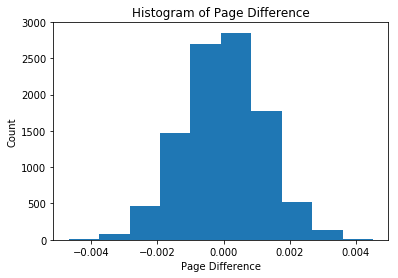

In [30]:

plt.hist(p_diffs)
plt.title('Histogram of Page Difference')
plt.xlabel('Page Difference') 
plt.ylabel('Count') 

What proportion of the **p_diffs** are greater than the actual difference observed in the dataset.

In [31]:
new = df3.query('landing_page == "new_page"')
new_mean = new['converted'].mean()
old = df3.query('landing_page == "old_page"')
old_mean = old['converted'].mean()
actual_diff = new_mean-old_mean
count = 0
for i in p_diffs:
    if i> actual_diff:
        count = count+1
 
#proportion of the p_diffs are greater than the actual difference observed
count/(len(p_diffs))

0.9038

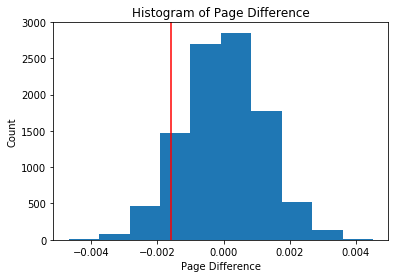

In [32]:

plt.hist(p_diffs)
plt.title('Histogram of Page Difference')
plt.xlabel('Page Difference') 
plt.ylabel('Count') 
plt.axvline(x= actual_diff, c='r');

**The proportion of the p_diffs (10k) - randomly simulated with the converted rate of all data in the ab_data set - which are greater than the actual difference observed in the ab_data set (actural_diff) is computed. The value computed is called in scientific studies as `p-value`. Almost 90 percent of the samples are higher than the actual difference, which means that the new_page is not significantly led to converting than the old_page.**

Use a built-in to achieve similar results with `n_old` and `n_new` refering the the number of rows associated with the old page and new pages, respectively.

In [33]:
n_convert_old = len(df3.query('converted==1 and landing_page=="old_page"')) 
n_convert_new = len(df3.query('converted==1 and landing_page=="new_page"')) 
n_old = len(df3.query('landing_page=="old_page"')) 
n_new = len(df3.query('landing_page=="new_page"')) 

n_convert_old,n_convert_new,n_old,n_new

(17489, 17264, 145274, 145310)

In [34]:
# Using stats.proportions_ztest to compute your test statistic and p-value
# alternativestr in [‘two-sided’, ‘smaller’, ‘larger’]

import statsmodels.api as sm
z_score, p_value = sm.stats.proportions_ztest([n_convert_old, n_convert_new], [n_old, n_new], alternative='smaller') 

z_score, p_value

(1.3109241984234394, 0.9050583127590245)

**z_score is less than the critical value of 95% confidence which is equal to the p-value. Hence we failed to reject the null hypothesis. From the two different ways to calculate the p_value, we concluded that we failed to reject the null hypothesis.**

<a id='regression'></a>
### Part III - A regression approach

In this final part, we will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>


**Since each row is one of the two cases (either a conversion or no conversion), a logistic regression would be eligible.**

Using **statsmodels** to fit the regression model, we will see if there is a significant difference in conversion based on which page a customer receives. First we need to create a column for the intercept, and create a dummy variable column for which page each user received by adding an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [35]:
df3['intercept'] = 1
df3['ab_page'] = pd.get_dummies(df3['group'])['treatment'] # 1 when an individual receives the treatment

df3.head()

C:\Users\altai\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\altai\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,11:48.6,control,old_page,0,1,0
1,804228,01:45.2,control,old_page,0,1,0
2,661590,55:06.2,treatment,new_page,0,1,1
3,853541,28:03.1,treatment,new_page,0,1,1
4,864975,52:26.2,control,old_page,1,1,0


Use **statsmodels** to import your regression model.  
Instantiate the model, and fit the model using the two columns (intercept and ab_page columns) to predict whether or not an individual converts.

In [36]:
import statsmodels.api as sm
model1 = sm.Logit(df3['converted'],df3[['intercept','ab_page']])
result1 = model1.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [37]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 7 columns):
user_id         290584 non-null int64
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
intercept       290584 non-null int64
ab_page         290584 non-null uint8
dtypes: int64(3), object(3), uint8(1)
memory usage: 15.8+ MB


In [38]:
# the summary of the model
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 13 Aug 2020   Pseudo R-squ.:               8.077e-06
Time:                        15:56:02   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

**The null and alternative hypotheses associated with the regression model vs the null and alternative hypotheses with AB testing in the Part II**



<center>Part III Logistic Regression <br>
$H_{1}$: $p_{new}$ - $p_{old}$ $\neq$ 0 <br>
$H_{0}$: $p_{new}$ - $p_{old}$ = 0</center><br><br>

<center>Part II AB Testing<br>
$H_{0}$: $p_{new}$ - $p_{old}$ <= 0 <br>
$H_{1}$: $p_{new}$ - $p_{old}$ > 0</center>




The p-value associated in **Part III** is 0.19 while the p-value in **Part II** was 0.90.

**Other factors that might influence could be added into the logistic regression model by adding arbitrary variables to increase the degree of freedom, which will decrease the precision of valid predictor variables. This might have disadvantages that the additional factors will influence the result.**

Now add an effect based on which country a user lives from **countries.csv** dataset by merging together the datasets on the approporiate rows. Dummy variables for these country columns are also created.


In [39]:
# read contries.csv and joint them at the user_id value

df = pd.read_csv('countries.csv')
df_joint = df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_joint.head()

,country,timestamp,group,landing_page,converted
user_id,,,,,
630000,US,26:06.5,treatment,new_page,0
630001,US,16:42.6,treatment,new_page,1
630002,US,20:56.4,control,old_page,0
630003,US,09:31.5,treatment,new_page,0
630004,US,23:58.8,treatment,new_page,0


In [40]:
### create dummy variables for these country columns
df_joint['ab_page'] = pd.get_dummies(df_joint['group'])['treatment'] # 1 when an individual receives the treatment

df_joint[['US', 'UK']] = pd.get_dummies(df_joint['country'])[['US', "UK"]]
df_joint.head()

,country,timestamp,group,landing_page,converted,ab_page,US,UK
user_id,,,,,,,,
630000,US,26:06.5,treatment,new_page,0,1,1,0
630001,US,16:42.6,treatment,new_page,1,1,1,0
630002,US,20:56.4,control,old_page,0,0,1,0
630003,US,09:31.5,treatment,new_page,0,1,1,0
630004,US,23:58.8,treatment,new_page,0,1,1,0


In [41]:
df_joint['US_ab_page'] = df_joint['US'] * df_joint['ab_page']

In [42]:
df_joint['UK_ab_page'] = df_joint['UK'] * df_joint['ab_page']

In [43]:
df_joint.head()

,country,timestamp,group,landing_page,converted,ab_page,US,UK,US_ab_page,UK_ab_page
user_id,,,,,,,,,,
630000,US,26:06.5,treatment,new_page,0,1,1,0,1,0
630001,US,16:42.6,treatment,new_page,1,1,1,0,1,0
630002,US,20:56.4,control,old_page,0,0,1,0,0,0
630003,US,09:31.5,treatment,new_page,0,1,1,0,1,0
630004,US,23:58.8,treatment,new_page,0,1,1,0,1,0


**Though we have looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.**  

In [44]:
df_joint.columns.values

array(['country', 'timestamp', 'group', 'landing_page', 'converted',
       'ab_page', 'US', 'UK', 'US_ab_page', 'UK_ab_page'], dtype=object)

In [45]:
df_joint['intercept'] = 1
train_cols=df_joint.columns.values[5:]
train_cols


array(['ab_page', 'US', 'UK', 'US_ab_page', 'UK_ab_page', 'intercept'],
      dtype=object)

In [46]:
model2 = sm.Logit(df_joint['converted'], df_joint[train_cols])
result2 = model2.fit()
result2.summary()

Optimization terminated successfully.
         Current function value: 0.366108
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290579
Method:                           MLE   Df Model:                            5
Date:                Thu, 13 Aug 2020   Pseudo R-squ.:               3.483e-05
Time:                        15:56:14   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1918
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
US             0.0175      0.038      0.465      0.642      -0.056       0.091
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
US_ab_page     0.0469      0.054      0.872      0.383      -0.059       0.152
UK_ab_page     0.0783      0.057      1.378      0.168      -0.033       0.190
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
==============================================================================
"""

In [47]:
coeff = result2.params
coeff_exp = np.exp(result2.params)
coeff_inv_exp = 1/np.exp(result2.params)

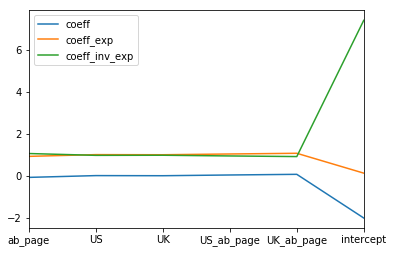

In [48]:
coeff.plot(label = 'coeff')
coeff_exp.plot(label = 'coeff_exp')
coeff_inv_exp.plot(label = 'coeff_inv_exp')
plt.legend()

Result1 and result2 show the summary of regression models with ab_page on conversion only and with ab_page on conversion, country, and interaction between page and country, respectively. As seen in the comparison of the results based on p-values, adding other factors (country) does not provide a statistical basis to reject the null hypothesis on Type I error of 5%.


## Reference

N/A